In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stock_pandas import StockDataFrame as SDF
from stockstats import StockDataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset - daily

In [2]:
df = pd.read_csv("../DataSets/bitcoin_prices6.csv")
df = df.dropna()
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close
50,1681917420,29421.40,29406.430454,29426.058056,29434.870560,29408.372141,29413.250040,29434.609765,29421.57
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78
...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27


In [3]:
sdf = StockDataFrame.retype(df)
sdf

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close
50,1681917420,29421.40,29406.430454,29426.058056,29434.870560,29408.372141,29413.250040,29434.609765,29421.57
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78
...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27


In [4]:
#Check that date is the index
print(sdf.index)

Int64Index([  50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
            ...
            1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000],
           dtype='int64', length=1951)


### Calculating RSI & RS

In [5]:
rsi = sdf.get('rsi_6')
rs = sdf.get('rs_6')
df['RSI'] = rsi
df['RS'] = rs

In [6]:
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close,rs_6,rsi_6,RSI,RS
50,1681917420,29421.40,29406.430454,29426.058056,29434.870560,29408.372141,29413.250040,29434.609765,29421.57,NaN,NaN,NaN,NaN
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55,0.000000,0.000000,0.000000,0.000000
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00,567.000000,99.823944,99.823944,567.000000
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95,635.400000,99.842866,99.842866,635.400000
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78,1.419292,58.665593,58.665593,1.419292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34,1.234218,55.241613,55.241613,1.234218
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04,1.011914,50.296092,50.296092,1.011914
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68,0.876440,46.707595,46.707595,0.876440
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27,1.733494,63.416779,63.416779,1.733494


In [7]:
del df['rsi_6']
del df['rs_6']

In [8]:
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close,RSI,RS
50,1681917420,29421.40,29406.430454,29426.058056,29434.870560,29408.372141,29413.250040,29434.609765,29421.57,NaN,NaN
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55,0.000000,0.000000
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00,99.823944,567.000000
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95,99.842866,635.400000
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78,58.665593,1.419292
...,...,...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34,55.241613,1.234218
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04,50.296092,1.011914
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68,46.707595,0.876440
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27,63.416779,1.733494


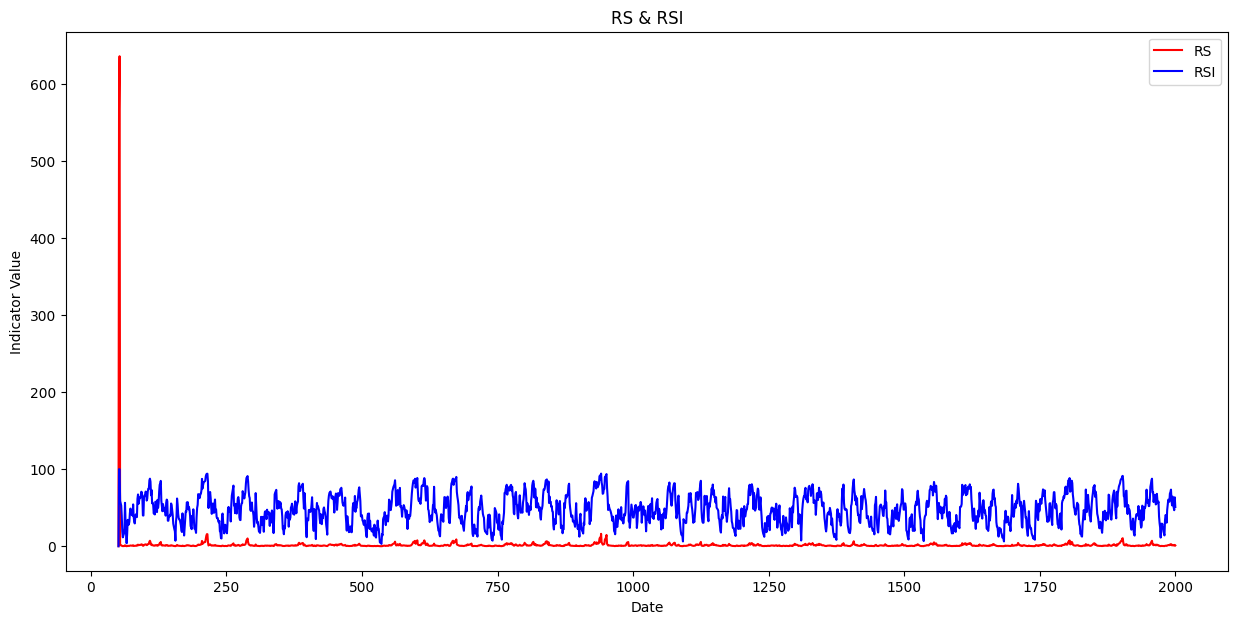

In [9]:
plt.figure(figsize=(15,7))
plt.plot(df['RS'],'r',label="RS")
plt.plot(df['RSI'], 'b', label="RSI")
plt.title("RS & RSI")
plt.ylabel("Indicator Value")
plt.xlabel("Date")
plt.legend()
plt.show()

In [10]:
del df['RSI']
del df['RS']

### Calculating MACD

In [11]:
macd = sdf.get('macd')
df['MACD'] = macd

In [12]:
macd_s = sdf.get('macds')
df['MACD_signal'] = macd_s

In [13]:
macd_h = sdf.get('macdh')
df['MACD_histogram'] = macd_h

In [14]:
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close,MACD,MACD_signal,MACD_histogram
50,1681917420,29421.40,29406.430454,29426.058056,29434.870560,29408.372141,29413.250040,29434.609765,29421.57,0.000000,0.000000,0.000000
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55,-0.000449,-0.000249,-0.000199
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00,0.292472,0.119719,0.172754
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95,0.452830,0.232561,0.220269
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78,0.324707,0.259972,0.064734
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34,-1.394152,-5.337407,3.943255
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04,-1.242176,-4.518361,3.276185
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68,-1.297212,-3.874131,2.576919
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27,-0.321219,-3.163549,2.842330


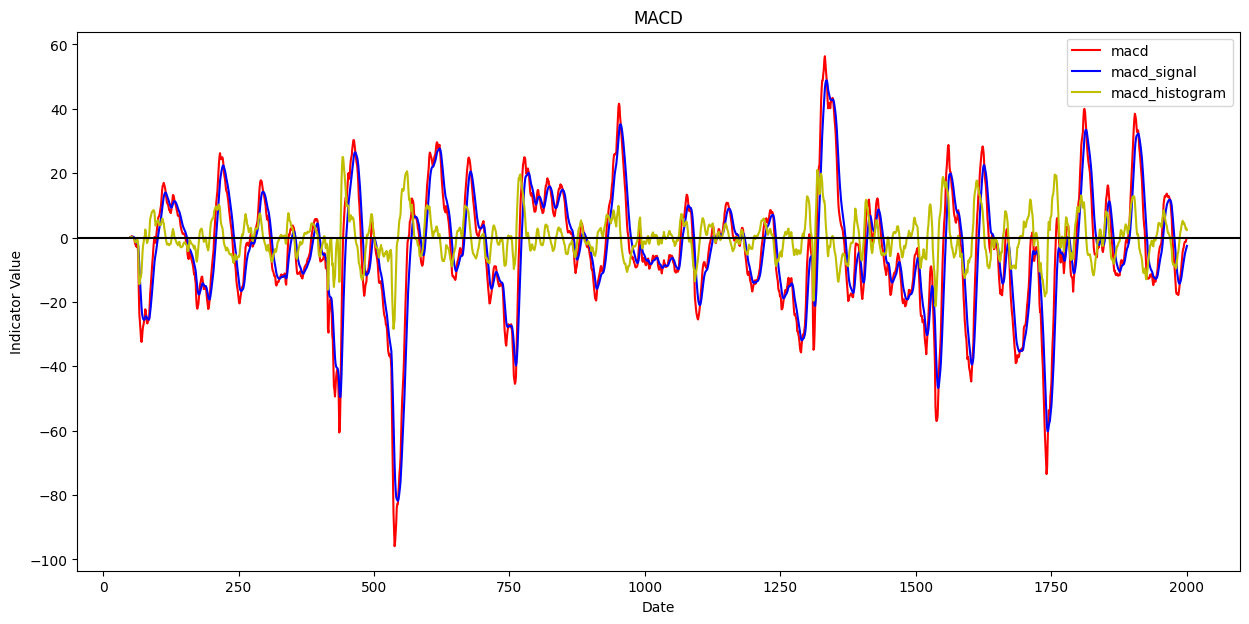

In [15]:
plt.figure(figsize=(15,7))
plt.plot(df['MACD'],'r',label="macd")
plt.plot(df['MACD_signal'], 'b', label="macd_signal")
plt.plot(df['MACD_histogram'], 'y', label="macd_histogram")
plt.axhline(y=0, color='black')
plt.title("MACD")
plt.ylabel("Indicator Value")
plt.xlabel("Date")
plt.legend()
plt.show()

In [16]:
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close,MACD,MACD_signal,MACD_histogram
50,1681917420,29421.40,29406.430454,29426.058056,29434.870560,29408.372141,29413.250040,29434.609765,29421.57,0.000000,0.000000,0.000000
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55,-0.000449,-0.000249,-0.000199
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00,0.292472,0.119719,0.172754
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95,0.452830,0.232561,0.220269
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78,0.324707,0.259972,0.064734
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34,-1.394152,-5.337407,3.943255
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04,-1.242176,-4.518361,3.276185
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68,-1.297212,-3.874131,2.576919
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27,-0.321219,-3.163549,2.842330


### Bollinger Bands

In [17]:
#Bollinger Bands Middle, Upper, Lower
bbs_m= sdf.get('boll')
bbs_u= sdf.get('boll_ub')
bbs_l=sdf.get('boll_lb')

df['BB_Upper'] = bbs_u
df['BB_Mid'] = bbs_m
df['BB_Low'] = bbs_l

In [18]:
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low
50,1681917420,29421.40,29406.430454,29426.058056,29434.870560,29408.372141,29413.250040,29434.609765,29421.57,0.000000,0.000000,0.000000,NaN,29421.570000,NaN
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55,-0.000449,-0.000249,-0.000199,29421.588284,29421.560000,29421.531716
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00,0.292472,0.119719,0.172754,29435.607058,29424.706667,29413.806275
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95,0.452830,0.232561,0.220269,29437.992614,29426.517500,29415.042386
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78,0.324707,0.259972,0.064734,29436.510513,29426.570000,29416.629487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34,-1.394152,-5.337407,3.943255,28268.619007,28235.606000,28202.592993
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04,-1.242176,-4.518361,3.276185,28269.661381,28236.182500,28202.703619
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68,-1.297212,-3.874131,2.576919,28270.432580,28237.337000,28204.241420
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27,-0.321219,-3.163549,2.842330,28271.956670,28239.564500,28207.172330


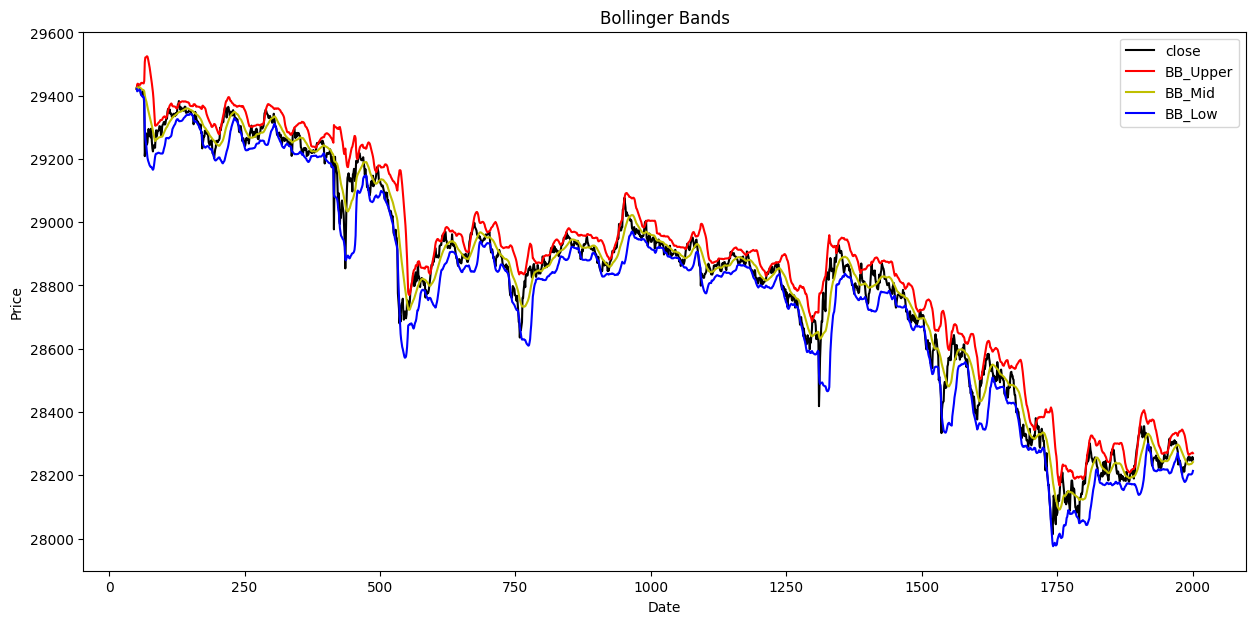

In [19]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], 'black', label="close")
plt.plot(df['BB_Upper'],'r',label="BB_Upper")
plt.plot(df['BB_Mid'], 'y', label="BB_Mid")
plt.plot(df['BB_Low'], 'b', label="BB_Low")
plt.title("Bollinger Bands")
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

## Oranizing the data

In [20]:
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low
50,1681917420,29421.40,29406.430454,29426.058056,29434.870560,29408.372141,29413.250040,29434.609765,29421.57,0.000000,0.000000,0.000000,NaN,29421.570000,NaN
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55,-0.000449,-0.000249,-0.000199,29421.588284,29421.560000,29421.531716
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00,0.292472,0.119719,0.172754,29435.607058,29424.706667,29413.806275
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95,0.452830,0.232561,0.220269,29437.992614,29426.517500,29415.042386
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78,0.324707,0.259972,0.064734,29436.510513,29426.570000,29416.629487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34,-1.394152,-5.337407,3.943255,28268.619007,28235.606000,28202.592993
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04,-1.242176,-4.518361,3.276185,28269.661381,28236.182500,28202.703619
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68,-1.297212,-3.874131,2.576919,28270.432580,28237.337000,28204.241420
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27,-0.321219,-3.163549,2.842330,28271.956670,28239.564500,28207.172330


In [21]:
df = df.dropna()

In [22]:
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,close,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,29421.55,-0.000449,-0.000249,-0.000199,29421.588284,29421.560000,29421.531716
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,29431.00,0.292472,0.119719,0.172754,29435.607058,29424.706667,29413.806275
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,29431.95,0.452830,0.232561,0.220269,29437.992614,29426.517500,29415.042386
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,29426.78,0.324707,0.259972,0.064734,29436.510513,29426.570000,29416.629487
55,1681917720,29426.78,29417.805395,29426.331594,29434.164488,29423.032637,29417.972321,29433.327890,29426.23,0.218065,0.248613,-0.030548,29435.408731,29426.513333,29417.617935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,28251.34,-1.394152,-5.337407,3.943255,28268.619007,28235.606000,28202.592993
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,28248.04,-1.242176,-4.518361,3.276185,28269.661381,28236.182500,28202.703619
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,28245.68,-1.297212,-3.874131,2.576919,28270.432580,28237.337000,28204.241420
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,28258.27,-0.321219,-3.163549,2.842330,28271.956670,28239.564500,28207.172330


In [23]:
df = df[['timestamp', '-1min', 'sma7', 'sma25', 'sma50', 'ema7', 'ema25', 'ema50', 'MACD', 'MACD_signal', 'MACD_histogram', 'BB_Upper', 'BB_Mid', 'BB_Low', 'close']]

In [24]:
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low,close
51,1681917480,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,-0.000449,-0.000249,-0.000199,29421.588284,29421.560000,29421.531716,29421.55
52,1681917540,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,0.292472,0.119719,0.172754,29435.607058,29424.706667,29413.806275,29431.00
53,1681917600,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,0.452830,0.232561,0.220269,29437.992614,29426.517500,29415.042386,29431.95
54,1681917660,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,0.324707,0.259972,0.064734,29436.510513,29426.570000,29416.629487,29426.78
55,1681917720,29426.78,29417.805395,29426.331594,29434.164488,29423.032637,29417.972321,29433.327890,0.218065,0.248613,-0.030548,29435.408731,29426.513333,29417.617935,29426.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1682034180,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,-1.394152,-5.337407,3.943255,28268.619007,28235.606000,28202.592993,28251.34
1997,1682034240,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,-1.242176,-4.518361,3.276185,28269.661381,28236.182500,28202.703619,28248.04
1998,1682034300,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,-1.297212,-3.874131,2.576919,28270.432580,28237.337000,28204.241420,28245.68
1999,1682034360,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,-0.321219,-3.163549,2.842330,28271.956670,28239.564500,28207.172330,28258.27


## Dataset Summary

In [25]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df_chart = df.copy()

In [26]:
df_chart

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low,close
51,2023-04-19 15:18:00,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,-0.000449,-0.000249,-0.000199,29421.588284,29421.560000,29421.531716,29421.55
52,2023-04-19 15:19:00,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,0.292472,0.119719,0.172754,29435.607058,29424.706667,29413.806275,29431.00
53,2023-04-19 15:20:00,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,0.452830,0.232561,0.220269,29437.992614,29426.517500,29415.042386,29431.95
54,2023-04-19 15:21:00,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,0.324707,0.259972,0.064734,29436.510513,29426.570000,29416.629487,29426.78
55,2023-04-19 15:22:00,29426.78,29417.805395,29426.331594,29434.164488,29423.032637,29417.972321,29433.327890,0.218065,0.248613,-0.030548,29435.408731,29426.513333,29417.617935,29426.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2023-04-20 23:43:00,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,-1.394152,-5.337407,3.943255,28268.619007,28235.606000,28202.592993,28251.34
1997,2023-04-20 23:44:00,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,-1.242176,-4.518361,3.276185,28269.661381,28236.182500,28202.703619,28248.04
1998,2023-04-20 23:45:00,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,-1.297212,-3.874131,2.576919,28270.432580,28237.337000,28204.241420,28245.68
1999,2023-04-20 23:46:00,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,-0.321219,-3.163549,2.842330,28271.956670,28239.564500,28207.172330,28258.27


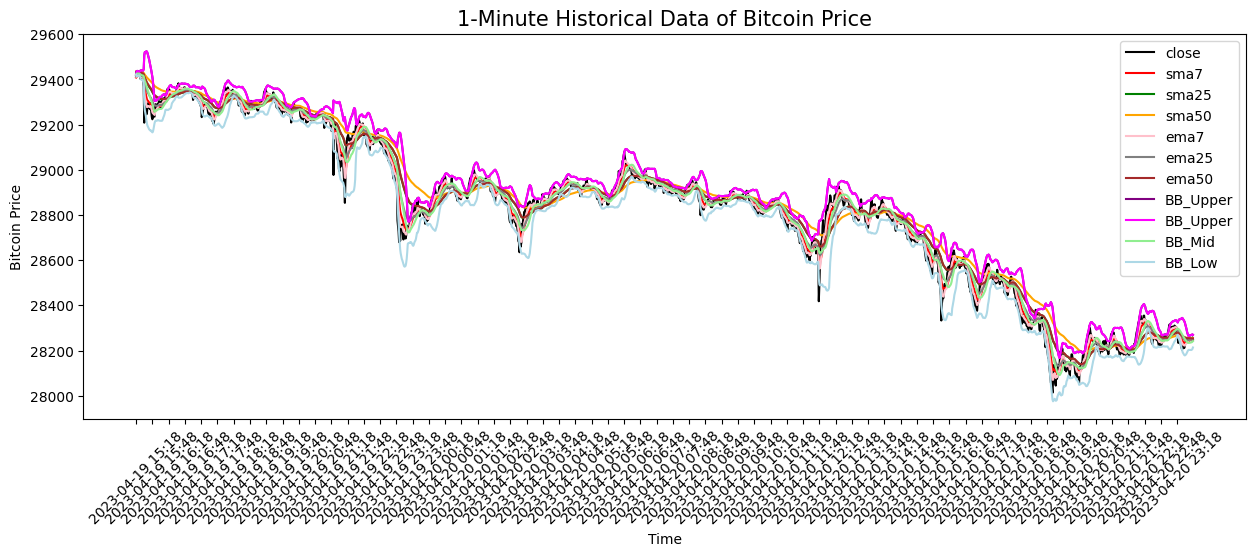

In [27]:
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'])
df_chart.set_index('timestamp', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['close'], color='black', label='close')
plt.plot(df_chart.index, df_chart['sma7'], color='red', label='sma7')
plt.plot(df_chart.index, df_chart['sma25'], color='green', label='sma25')
plt.plot(df_chart.index, df_chart['sma50'], color='orange', label='sma50')
plt.plot(df_chart.index, df_chart['ema7'], color='pink', label='ema7')
plt.plot(df_chart.index, df_chart['ema25'], color='gray', label='ema25')
plt.plot(df_chart.index, df_chart['ema50'], color='brown', label='ema50')
##plt.plot(df_chart.index, df_chart['MACD'], color='blue', label='MACD')
##plt.plot(df_chart.index, df_chart['MACD_signal'], color='cyan', label='MACD_signal')
##plt.plot(df_chart.index, df_chart['MACD_histogram'], color='yellow', label='MACD_histogram')
plt.plot(df_chart.index, df_chart['BB_Upper'], color='purple', label='BB_Upper')
plt.plot(df_chart.index, df_chart['BB_Upper'], color='magenta', label='BB_Upper')
plt.plot(df_chart.index, df_chart['BB_Mid'], color='lightgreen', label='BB_Mid')
plt.plot(df_chart.index, df_chart['BB_Low'], color='lightblue', label='BB_Low')
plt.title('1-Minute Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

tick_values = pd.date_range(start=df_chart.index[0], end=df_chart.index[-1], freq='30T')
tick_labels = [date.strftime('%Y-%m-%d %H:%M') for date in tick_values]
plt.xticks(tick_values, tick_labels, rotation=45)

plt.show()

## Data featuring

In [34]:
feature_df = df.iloc[:,1:15]
feature_df

,-1min,sma7,sma25,sma50,ema7,ema25,ema50,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low,close
51,29421.57,29408.590389,29425.877734,29434.604149,29411.666606,29413.888498,29434.097617,-0.000449,-0.000249,-0.000199,29421.588284,29421.560000,29421.531716,29421.55
52,29421.55,29411.791762,29426.082624,29434.532066,29416.499955,29415.204768,29433.976142,0.292472,0.119719,0.172754,29435.607058,29424.706667,29413.806275,29431.00
53,29431.00,29414.671510,29426.317319,29434.480425,29420.362466,29416.492862,29433.896685,0.452830,0.232561,0.220269,29437.992614,29426.517500,29415.042386,29431.95
54,29431.95,29416.401294,29426.335827,29434.326416,29421.966849,29417.284181,29433.617600,0.324707,0.259972,0.064734,29436.510513,29426.570000,29416.629487,29426.78
55,29426.78,29417.805395,29426.331594,29434.164488,29423.032637,29417.972321,29433.327890,0.218065,0.248613,-0.030548,29435.408731,29426.513333,29417.617935,29426.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,28257.02,28247.143121,28254.406555,28255.956406,28250.350487,28248.539145,28254.565232,-1.394152,-5.337407,3.943255,28268.619007,28235.606000,28202.592993,28251.34
1997,28251.34,28247.271247,28254.151893,28255.798078,28249.772865,28248.500749,28254.309340,-1.242176,-4.518361,3.276185,28269.661381,28236.182500,28202.703619,28248.04
1998,28248.04,28247.043926,28253.813017,28255.595717,28248.749649,28248.283769,28253.970935,-1.297212,-3.874131,2.576919,28270.432580,28237.337000,28204.241420,28245.68
1999,28245.68,28248.647651,28253.991297,28255.649202,28251.129737,28249.051940,28254.139526,-0.321219,-3.163549,2.842330,28271.956670,28239.564500,28207.172330,28258.27


In [33]:
scaler = StandardScaler()
df_ft = feature_df[:, 1:14]
df_ft = scaler.fit_transform(df_ft.values)
df_ft = pd.DataFrame(columns=df_ft. columns,
                    data=df_ft,
                    index=df_ft.index)

InvalidIndexError: (slice(None, None, None), slice(1, 14, None))

In [ ]:
def lstm_split(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps + 1):
        X.append (data[i:i + n_steps, : - 1])
        y.append(target[i + n_steps - 1, -1])
    return np.array(X), np.array(y)

In [ ]:
X1, y1 = lstm_split(df_ft.values, feature_df, n_steps=50)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## LSTM model

In [ ]:
model = Sequential ()
model. add(LSTM(units = 100, return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])))
model. add (Dropout (0.2))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.2))
model. add(LSTM(units = 100, return_sequences= True))
model. add(Dropout (0.2))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

## model Summary

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

## Evaluate

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, f'{average_error_rate:.2f}%', fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

In [ ]:
y_test_index = range(len(y_test))

y_test_series = pd.Series(y_test.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred.reshape(-1,), index=y_test_index)

plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price', s=3)
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## If you want to predict the next Bitcoin price using current price...

In [ ]:
cur = pd.read_csv("../Current_price/current.csv")
cur = cur.dropna()
cur['timestamp'] = pd.to_datetime(cur['timestamp'], unit='s')
cur

In [ ]:
feature_cur = cur.iloc[:,1:15]
feature_cur

In [ ]:
scaler = StandardScaler()
cur_ft = cur_ft.iloc[:,1:14]
cur_ft = scaler.fit_transform(feature_cur.values)
cur_ft = pd.DataFrame(columns=feature_cur. columns,
                    data=cur_ft,
                    index=feature_cur.index)

In [ ]:
cur_ft

In [ ]:
cur_ft.shape

In [ ]:
X_cur, y_target_cur = lstm_split(cur_ft.values, feature_cur, n_steps=50)

In [ ]:
print(X_cur.shape, y_target_cur)

In [ ]:
y_pred_cur = model.predict(X_cur)

In [ ]:
y_pred_cur

In [ ]:
y_target_cur

In [ ]:
unscaled_dy_pred_cur = scaler.inverse_transform(y_pred_cur)